In [1]:
import torch
import torch.nn as nn
import time
import argparse

import os
import datetime

from torch.distributions.categorical import Categorical

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("cpu"); gpu_id = -1 # select CPU

gpu_id = '0' # select a single GPU  
#gpu_id = '2,3' # select multiple GPUs  
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))   
    
print(device)
print('pytorch version = ',torch.__version__)

GPU name: GeForce RTX 2080 Ti, gpu_id: 0
cuda
pytorch version =  1.10.0


In [2]:
import math
import numpy as np
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
class TransEncoderNet(nn.Module):
    """
    Encoder network based on self-attention transformer
    Inputs :  
      h of size      (bsz, nb_nodes, dim_emb)    batch of input cities
    Outputs :  
      h of size      (bsz, nb_nodes, dim_emb)    batch of encoded cities
      score of size  (bsz, nb_nodes, nb_nodes+1) batch of attention scores
    """
    
    def __init__(self, nb_layers, dim_emb, nb_heads, dim_ff, batchnorm):
        super(TransEncoderNet, self).__init__()
        assert dim_emb == nb_heads* (dim_emb//nb_heads) # check if dim_emb is divisible by nb_heads
        self.MHA_layers = nn.ModuleList( [nn.MultiheadAttention(dim_emb, nb_heads) for _ in range(nb_layers)] )
        self.linear1_layers = nn.ModuleList( [nn.Linear(dim_emb, dim_ff) for _ in range(nb_layers)] )
        self.linear2_layers = nn.ModuleList( [nn.Linear(dim_ff, dim_emb) for _ in range(nb_layers)] )   
        if batchnorm:
            self.norm1_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
        else:
            self.norm1_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
        self.nb_layers = nb_layers
        self.nb_heads = nb_heads
        self.batchnorm = batchnorm
        
    def forward(self, h):      
        # PyTorch nn.MultiheadAttention requires input size (seq_len, bsz, dim_emb) 
        h = h.transpose(0,1) # size(h)=(nb_nodes, bsz, dim_emb)  
        # L layers
        for i in range(self.nb_layers):
            h_rc = h # residual connection, size(h_rc)=(nb_nodes, bsz, dim_emb)
            h, score = self.MHA_layers[i](h, h, h) # size(h)=(nb_nodes, bsz, dim_emb), size(score)=(bsz, nb_nodes, nb_nodes)
            # add residual connection
            
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                # Pytorch nn.BatchNorm1d requires input size (bsz, dim, seq_len)
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm1_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm1_layers[i](h)       # size(h)=(nb_nodes, bsz, dim_emb) 
            # feedforward
            h_rc = h # residual connection
            h = self.linear2_layers[i](torch.relu(self.linear1_layers[i](h)))
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm2_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm2_layers[i](h) # size(h)=(nb_nodes, bsz, dim_emb)
        # Transpose h
        h = h.transpose(0,1) # size(h)=(bsz, nb_nodes, dim_emb)
        return h, score
    

class Attention(nn.Module):
    def __init__(self, n_hidden):
        super(Attention, self).__init__()
        self.size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        v  = torch.FloatTensor(n_hidden)
        self.v  = nn.Parameter(v)
        self.v.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        # parameters for pointer attention
        self.Wref = nn.Linear(n_hidden, n_hidden)
        self.Wq = nn.Linear(n_hidden, n_hidden)
    
    
    def forward(self, q, ref):       # query and reference
        self.batch_size = q.size(0)
        self.size = int(ref.size(0) / self.batch_size)
        q = self.Wq(q)     # (B, dim)
        ref = self.Wref(ref)
        ref = ref.view(self.batch_size, self.size, self.dim)  # (B, size, dim)
        
        q_ex = q.unsqueeze(1).repeat(1, self.size, 1) # (B, size, dim)
        # v_view: (B, dim, 1)
        v_view = self.v.unsqueeze(0).expand(self.batch_size, self.dim).unsqueeze(2)
        
        # (B, size, dim) * (B, dim, 1)
        u = torch.bmm(torch.tanh(q_ex + ref), v_view).squeeze(2)
        
        return u, ref
    
class LSTM(nn.Module):
    def __init__(self, n_hidden):
        super(LSTM, self).__init__()
        
        # parameters for input gate
        self.Wxi = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whi = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wci = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for forget gate
        self.Wxf = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whf = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wcf = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for cell gate
        self.Wxc = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whc = nn.Linear(n_hidden, n_hidden)    # W(ht)
        
        # parameters for forget gate
        self.Wxo = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Who = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wco = nn.Linear(n_hidden, n_hidden)    # w(ct)
    
    
    def forward(self, x, h, c):       # query and reference
        
        # input gate
        i = torch.sigmoid(self.Wxi(x) + self.Whi(h) + self.wci(c))
        # forget gate
        f = torch.sigmoid(self.Wxf(x) + self.Whf(h) + self.wcf(c))
        # cell gate
        c = f * c + i * torch.tanh(self.Wxc(x) + self.Whc(h))
        # output gate
        o = torch.sigmoid(self.Wxo(x) + self.Who(h) + self.wco(c))
        
        h = o * torch.tanh(c)
        
        return h, c

class HPN(nn.Module):
    def __init__(self, n_feature, n_hidden):

        super(HPN, self).__init__()
        self.city_size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        # lstm for first turn
        #self.lstm0 = nn.LSTM(n_hidden, n_hidden)
        
        # pointer layer
        self.pointer = Attention(n_hidden)
        self.TransPointer = Attention(n_hidden)
        
        # lstm encoder
        self.encoder = LSTM(n_hidden)
        
        # trainable first hidden input
        h0 = torch.FloatTensor(n_hidden)
        c0 = torch.FloatTensor(n_hidden)
        # trainable latent variable coefficient
        print('here') 
        alpha = torch.ones(1).cuda()       
        self.h0 = nn.Parameter(h0)
        self.c0 = nn.Parameter(c0)
        
        self.alpha = nn.Parameter(alpha)
        self.h0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        self.c0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        r1 = torch.ones(1)
        r2 = torch.ones(1)
        r3 = torch.ones(1)
        self.r1 = nn.Parameter(r1)
        self.r2 = nn.Parameter(r2)
        self.r3 = nn.Parameter(r3)
        
        # embedding
        self.embedding_x = nn.Linear(n_feature, n_hidden)
        self.embedding_all = nn.Linear(n_feature, n_hidden)
        self.Transembedding_all = TransEncoderNet(6, 128, 8, 512, batchnorm=True)#6,128,8,512
        
        # vector to start decoding 
        self.start_placeholder = nn.Parameter(torch.randn(n_hidden))
        
        # weights for GNN
        self.W1 = nn.Linear(n_hidden, n_hidden)
        self.W2 = nn.Linear(n_hidden, n_hidden)
        self.W3 = nn.Linear(n_hidden, n_hidden)
        
        # aggregation function for GNN
        self.agg_1 = nn.Linear(n_hidden, n_hidden)
        self.agg_2 = nn.Linear(n_hidden, n_hidden)
        self.agg_3 = nn.Linear(n_hidden, n_hidden)
    
    
    def forward(self,context,Transcontext, x, X_all, mask, h=None, c=None, latent=None):
        '''
        Inputs (B: batch size, size: city size, dim: hidden dimension)
        
        x: current city coordinate (B, 2)
        X_all: all cities' cooridnates (B, size, 2)
        mask: mask visited cities
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        latent: latent pointer vector from previous layer (B, size, dim)
        
        Outputs
        
        softmax: probability distribution of next city (B, size)
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        latent_u: latent pointer vector for next layer
        '''
        
        self.batch_size = X_all.size(0)
        self.city_size = X_all.size(1)
        
        # Check if this the first iteration loop
        if h is None or c is None:
            x          = self.start_placeholder    
            context = self.embedding_all(X_all)
            Transcontext,_ = self.Transembedding_all(context)
            
            # =============================
            # graph neural network encoder
            # =============================

            # (B, size, dim)
            context = context.reshape(-1, self.dim)
            Transcontext = Transcontext.reshape(-1, self.dim)

            context = self.r1 * self.W1(context)\
                + (1-self.r1) * F.relu(self.agg_1(context/(self.city_size-1)))

            context = self.r2 * self.W2(context)\
                + (1-self.r2) * F.relu(self.agg_2(context/(self.city_size-1)))

            context = self.r3 * self.W3(context)\
                + (1-self.r3) * F.relu(self.agg_3(context/(self.city_size-1)))
            h0 = self.h0.unsqueeze(0).expand(self.batch_size, self.dim)
            c0 = self.c0.unsqueeze(0).expand(self.batch_size, self.dim)

            h0 = h0.unsqueeze(0).contiguous()
            c0 = c0.unsqueeze(0).contiguous()
            
            # let h0, c0 be the hidden variable of first turn
            h = h0.squeeze(0)
            c = c0.squeeze(0)
        else:
            x          = self.embedding_x(x)
        # LSTM encoder
        h, c = self.encoder(x, h, c)
        # query vector
        q = h
        # pointer
        u1, _ = self.pointer(q, context)
        u2 ,_ = self.TransPointer(q,Transcontext)
        # Avg Agg between the two attention vectors
        u = torch.maximum(u1,u2)
        latent_u = u.clone()
        u = 10 * torch.tanh(u) + mask
        return context,Transcontext,F.softmax(u, dim=1), h, c, latent_u

# daniel rectangle feature handle

In [3]:
'''
This part I designed the rectangle-characterized TSP, that means for every step the agent walk through a corner,
then he travel through the whole rectangle using zig-zag, finally he ends up at one of the rest corners of 
the rextangle, so, it equals the agent walk through three points at one step, in practice, I add three points into 
mask to make them unselectable.
'''
def euler_distance(point_1,point_2):
    return torch.sum((point_1 - point_2) ** 2, dim=1) ** 0.5
def mintime_distance(point_1,point_2):
    dis = (point_1 - point_2)**2
    reward = torch.maximum(dis[:,0],dis[:,1])**0.5
    return reward
def calculate_vector(item_1,item_2):
    slope_temp = item_1 - item_2
    return slope_temp
def rectangle_process(b_temp,f_temp,idx,Y,Y0,mask,k,B,barrier_points):
    Y1 = Y[zero_to_bsz, idx.data].clone()
    if Y0 != None:
        vector = calculate_vector(Y1,Y0) # tensor of 256 points - tensor of 256 points
        euler = euler_distance(Y1,Y0)
        vector_barrier = torch.Tensor([]).cuda()
        euler_barrier = torch.Tensor([]).cuda()
        for i in range(len(barrier_points[0])):
            barriers = barrier_points[:,i]
            vector_temp = calculate_vector(barriers,Y0)
            vector_barrier = torch.cat((vector_barrier,vector_temp),0)
            euler_barrier = torch.cat((euler_barrier,euler_distance(barriers,Y0)), 0)
        vector_barrier = torch.reshape(vector_barrier,(len(barrier_points[0]),B,len(barrier_points[0][0])))
        euler_barrier = torch.reshape(euler_barrier,(len(barrier_points[0]),B))
    rectangle_inf = idx/4
    feature_table = f_temp.outcorner_getout(rectangle_inf,B)
    feature_table = torch.Tensor(feature_table).type(torch.long)
    Y_corner = Y[zero_to_bsz, feature_table[:,0].data].clone()
    if k ==0:
        reward = 0
    if k > 0:
        reward = euler_distance(Y1,Y0)
        reward += euler_distance(Y_corner,Y1) 
        reward += b_temp.barrier_detect(vector_barrier, euler_barrier, vector, euler).cuda()
    mask[zero_to_bsz, idx.data] += -np.inf
    mask[zero_to_bsz, feature_table[:,0].data] += -np.inf
    mask[zero_to_bsz, feature_table[:,1].data ] += -np.inf    
    mask[zero_to_bsz, feature_table[:,2].data ] += -np.inf 
    return reward, Y_corner, Y_corner
def rectangle_process_actor(b_temp,f_temp,idx,Y,Y0,mask,k,B,i,path_gazebo,barrier_points):
    Y1 = Y[zero_to_bsz, idx.data].clone()
    if Y0 != None:
        vector = calculate_vector(Y1,Y0) # tensor of 256 points - tensor of 256 points
        euler = euler_distance(Y1,Y0)
        vector_barrier = torch.Tensor([]).cuda()
        euler_barrier = torch.Tensor([]).cuda()
        for j in range(len(barrier_points[0])):
            barriers = barrier_points[:,j]
            vector_temp = calculate_vector(barriers,Y0)
            vector_barrier = torch.cat((vector_barrier,vector_temp),0)
            euler_barrier = torch.cat((euler_barrier,euler_distance(barriers,Y0)), 0)
        vector_barrier = torch.reshape(vector_barrier,(len(barrier_points[0]),B,len(barrier_points[0][0])))
        euler_barrier = torch.reshape(euler_barrier,(len(barrier_points[0]),B))
    rectangle_inf = idx/4
    feature_table = f_temp.outcorner_getout(rectangle_inf,B)
    feature_table = torch.Tensor(feature_table).type(torch.long)
    Y_corner = Y[zero_to_bsz, feature_table[:,0].data].clone()
    if k ==0:
        reward = 0
    if k > 0:
        reward = euler_distance(Y1,Y0)
        reward += euler_distance(Y_corner,Y1) 
        reward += b_temp.barrier_detect(vector_barrier, euler_barrier, vector, euler).cuda()
    if i % 200 == 0:
        temp_gazebo_path = b_temp.extract_barrier_path()
        temp_gazebo_path.extend([idx.data[0].tolist(),feature_table[:,0].data[0].tolist()])
        path_gazebo.append(temp_gazebo_path)
    mask[zero_to_bsz, idx.data] += -np.inf
    mask[zero_to_bsz, feature_table[:,0].data] += -np.inf
    mask[zero_to_bsz, feature_table[:,1].data ] += -np.inf    
    mask[zero_to_bsz, feature_table[:,2].data ] += -np.inf 
    return reward, Y_corner, Y_corner

prepare to train
Hyper parameters:
learning rate 0.0001
batch size 256
steps 2500
epoch 100
here
here
Re-start training with saved checkpoint file=checkpoint/checkpoint_21-12-13--20-14-17-n136-gpu0.pkl
  Checkpoint at epoch= 0 and time=131.877min

epoch:1, batch:50/2500, reward:4563.11572265625
epoch:1, batch:100/2500, reward:4563.1376953125
epoch:1, batch:150/2500, reward:4532.8427734375
epoch:1, batch:200/2500, reward:4493.56640625
record the last path to gazebo for showing up
[2, 1, 7, 6]
[12, 15, 113, 115]


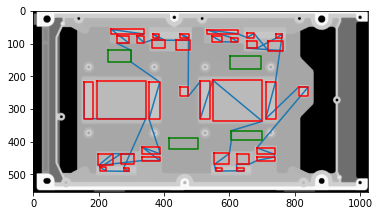

epoch:1, batch:250/2500, reward:4474.71142578125
epoch:1, batch:300/2500, reward:4441.9833984375
epoch:1, batch:350/2500, reward:4386.9052734375
epoch:1, batch:400/2500, reward:4359.0634765625
record the last path to gazebo for showing up
[12, 15, 115, 113]


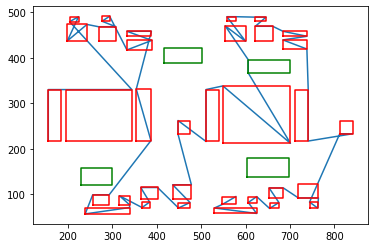

epoch:1, batch:450/2500, reward:4369.8740234375
epoch:1, batch:500/2500, reward:4320.5205078125
epoch:1, batch:550/2500, reward:4322.12158203125
epoch:1, batch:600/2500, reward:4290.787109375
record the last path to gazebo for showing up
[12, 15, 112, 114]


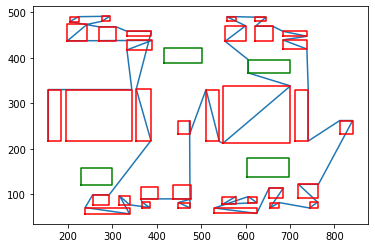

epoch:1, batch:650/2500, reward:4242.98193359375
epoch:1, batch:700/2500, reward:4238.6640625
epoch:1, batch:750/2500, reward:4221.796875
epoch:1, batch:800/2500, reward:4213.7060546875
record the last path to gazebo for showing up
[12, 15, 112, 114]


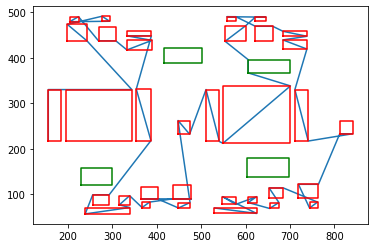

epoch:1, batch:850/2500, reward:4155.8154296875
epoch:1, batch:900/2500, reward:4155.30419921875
epoch:1, batch:950/2500, reward:4142.19189453125
epoch:1, batch:1000/2500, reward:4124.3583984375
record the last path to gazebo for showing up
[12, 15, 112, 114]


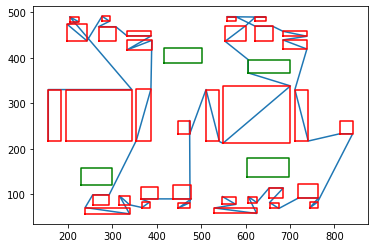

epoch:1, batch:1050/2500, reward:4150.4453125
epoch:1, batch:1100/2500, reward:4074.373046875
epoch:1, batch:1150/2500, reward:4081.0830078125
epoch:1, batch:1200/2500, reward:4078.76123046875
record the last path to gazebo for showing up
[12, 15, 112, 114]


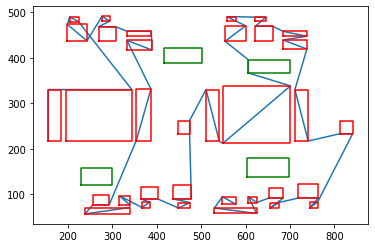

epoch:1, batch:1250/2500, reward:4023.4130859375
epoch:1, batch:1300/2500, reward:3982.419677734375
epoch:1, batch:1350/2500, reward:4029.06787109375
epoch:1, batch:1400/2500, reward:4014.064453125
record the last path to gazebo for showing up
[12, 15, 112, 114]
[14, 13, 62, 61]


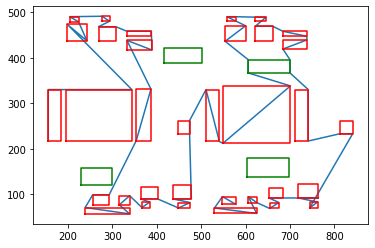

epoch:1, batch:1450/2500, reward:4007.78662109375
epoch:1, batch:1500/2500, reward:3990.04052734375
epoch:1, batch:1550/2500, reward:4004.9111328125
epoch:1, batch:1600/2500, reward:3955.768798828125
record the last path to gazebo for showing up
[12, 15, 112, 114]


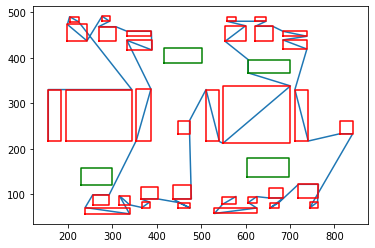

epoch:1, batch:1650/2500, reward:3956.9990234375
epoch:1, batch:1700/2500, reward:3947.30859375
epoch:1, batch:1750/2500, reward:3949.93017578125
epoch:1, batch:1800/2500, reward:3927.076171875
record the last path to gazebo for showing up
[12, 15, 112, 114]
[14, 13, 63, 61]


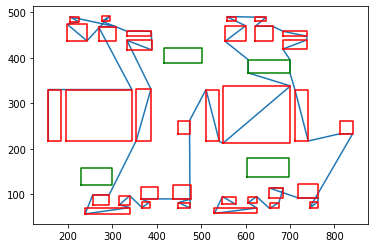

epoch:1, batch:1850/2500, reward:3942.66259765625
epoch:1, batch:1900/2500, reward:3913.72412109375
epoch:1, batch:1950/2500, reward:3924.888671875
epoch:1, batch:2000/2500, reward:3975.048828125
record the last path to gazebo for showing up
[12, 15, 112, 114]
[14, 13, 63, 61]


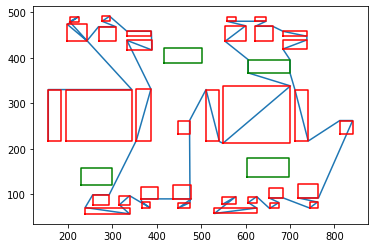

epoch:1, batch:2050/2500, reward:3928.60009765625
epoch:1, batch:2100/2500, reward:3930.53125
epoch:1, batch:2150/2500, reward:3931.783203125
epoch:1, batch:2200/2500, reward:3922.68994140625
record the last path to gazebo for showing up
[12, 15, 112, 114]
[14, 13, 63, 61]


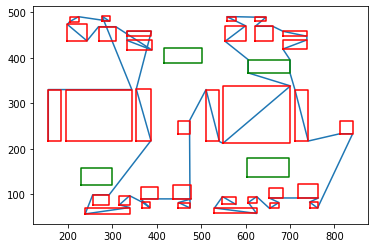

epoch:1, batch:2250/2500, reward:3917.45654296875
epoch:1, batch:2300/2500, reward:3907.54443359375
epoch:1, batch:2350/2500, reward:3917.69873046875
epoch:1, batch:2400/2500, reward:3918.0068359375
record the last path to gazebo for showing up
[9, 10, 123, 122]
[12, 15, 116, 117]
[14, 13, 63, 61]


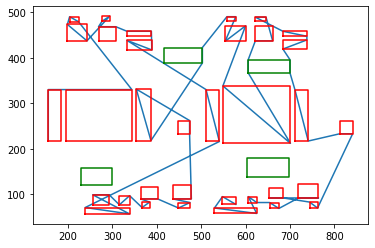

epoch:1, batch:2450/2500, reward:3899.58203125
epoch:1, batch:2500/2500, reward:3886.61376953125
Avg Actor 3861.37255859375 --- Avg Critic 4331.880859375
My actor is going on the right road Hallelujah :) Updated
Epoch: 1, epoch time: 129.612min, tot time: 0.182day, L_actor: 3861.373, L_critic: 4331.881, update: True
Save Checkpoints
epoch:2, batch:50/2500, reward:3888.07373046875
epoch:2, batch:100/2500, reward:3883.903564453125
epoch:2, batch:150/2500, reward:3873.73974609375
epoch:2, batch:200/2500, reward:3868.38232421875
record the last path to gazebo for showing up
[12, 15, 112, 114]
[14, 13, 63, 61]


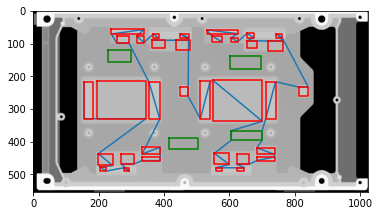

epoch:2, batch:250/2500, reward:3866.15478515625
epoch:2, batch:300/2500, reward:3863.344970703125
epoch:2, batch:350/2500, reward:3871.054931640625
epoch:2, batch:400/2500, reward:3867.74169921875
record the last path to gazebo for showing up
[12, 15, 112, 114]
[14, 13, 63, 61]


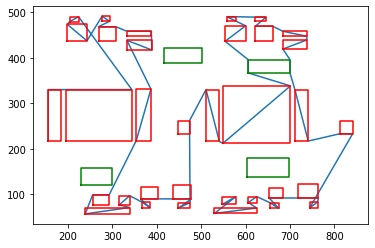

epoch:2, batch:450/2500, reward:3869.5439453125
epoch:2, batch:500/2500, reward:3836.0517578125
epoch:2, batch:550/2500, reward:3812.59130859375
epoch:2, batch:600/2500, reward:3803.365234375
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


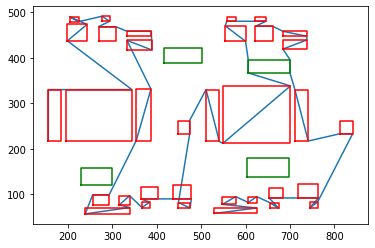

epoch:2, batch:650/2500, reward:3792.51318359375
epoch:2, batch:700/2500, reward:3812.1396484375
epoch:2, batch:750/2500, reward:3799.19189453125
epoch:2, batch:800/2500, reward:3793.59716796875
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


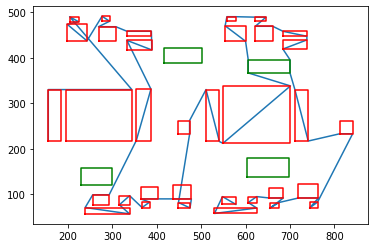

epoch:2, batch:850/2500, reward:3808.2880859375
epoch:2, batch:900/2500, reward:3805.785888671875
epoch:2, batch:950/2500, reward:3810.75146484375
epoch:2, batch:1000/2500, reward:3803.48291015625
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


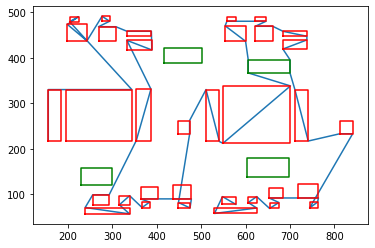

epoch:2, batch:1050/2500, reward:3796.53369140625
epoch:2, batch:1100/2500, reward:3799.984619140625
epoch:2, batch:1150/2500, reward:3789.36474609375
epoch:2, batch:1200/2500, reward:3787.531982421875
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


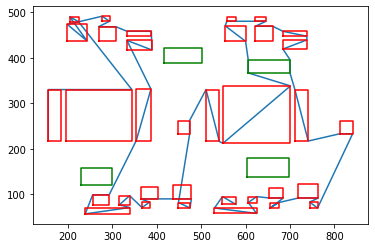

epoch:2, batch:1250/2500, reward:3812.18896484375
epoch:2, batch:1300/2500, reward:3801.379150390625
epoch:2, batch:1350/2500, reward:3778.968994140625
epoch:2, batch:1400/2500, reward:3794.376953125
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


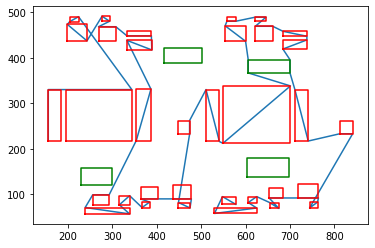

epoch:2, batch:1450/2500, reward:3780.11083984375
epoch:2, batch:1500/2500, reward:3779.71630859375
epoch:2, batch:1550/2500, reward:3781.033447265625
epoch:2, batch:1600/2500, reward:3777.208984375
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


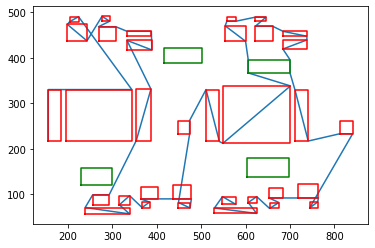

epoch:2, batch:1650/2500, reward:3779.573486328125
epoch:2, batch:1700/2500, reward:3766.4736328125
epoch:2, batch:1750/2500, reward:3785.0107421875
epoch:2, batch:1800/2500, reward:3796.8037109375
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


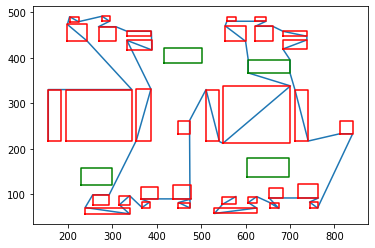

epoch:2, batch:1850/2500, reward:3770.37890625
epoch:2, batch:1900/2500, reward:3775.97314453125
epoch:2, batch:1950/2500, reward:3781.2177734375
epoch:2, batch:2000/2500, reward:3765.8740234375
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


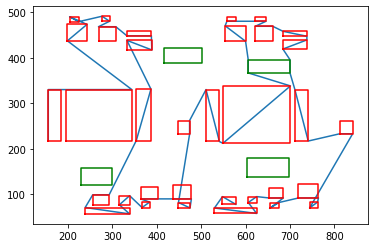

epoch:2, batch:2050/2500, reward:3770.257080078125
epoch:2, batch:2100/2500, reward:3769.127197265625
epoch:2, batch:2150/2500, reward:3765.52099609375
epoch:2, batch:2200/2500, reward:3748.119384765625
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


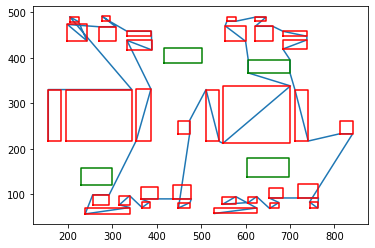

epoch:2, batch:2250/2500, reward:3752.93017578125
epoch:2, batch:2300/2500, reward:3732.65966796875
epoch:2, batch:2350/2500, reward:3760.11669921875
epoch:2, batch:2400/2500, reward:3725.05517578125
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


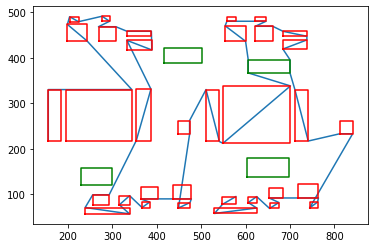

epoch:2, batch:2450/2500, reward:3724.146240234375
epoch:2, batch:2500/2500, reward:3711.2509765625
Avg Actor 3672.813720703125 --- Avg Critic 3861.37255859375
My actor is going on the right road Hallelujah :) Updated
Epoch: 2, epoch time: 130.983min, tot time: 0.273day, L_actor: 3672.814, L_critic: 3861.373, update: True
Save Checkpoints
epoch:3, batch:50/2500, reward:3714.57177734375
epoch:3, batch:100/2500, reward:3702.704345703125
epoch:3, batch:150/2500, reward:3694.619140625
epoch:3, batch:200/2500, reward:3695.771728515625
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


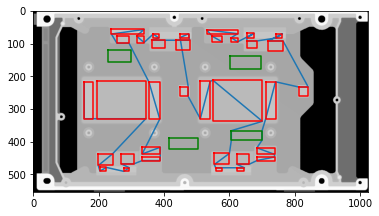

epoch:3, batch:250/2500, reward:3712.8017578125
epoch:3, batch:300/2500, reward:3720.689697265625
epoch:3, batch:350/2500, reward:3689.183837890625
epoch:3, batch:400/2500, reward:3684.671142578125
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


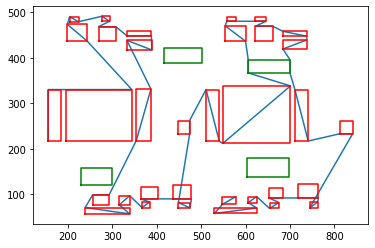

epoch:3, batch:450/2500, reward:3701.92431640625
epoch:3, batch:500/2500, reward:3679.98681640625
epoch:3, batch:550/2500, reward:3683.452392578125
epoch:3, batch:600/2500, reward:3691.177490234375
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


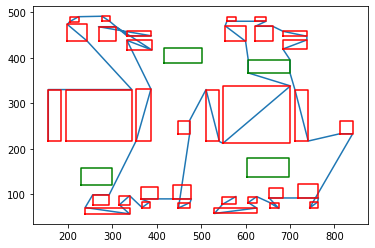

epoch:3, batch:650/2500, reward:3675.650146484375
epoch:3, batch:700/2500, reward:3683.5634765625
epoch:3, batch:750/2500, reward:3677.779296875
epoch:3, batch:800/2500, reward:3672.08203125
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


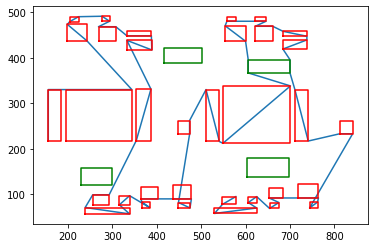

epoch:3, batch:850/2500, reward:3661.030517578125
epoch:3, batch:900/2500, reward:3668.41455078125
epoch:3, batch:950/2500, reward:3677.0908203125
epoch:3, batch:1000/2500, reward:3678.548828125
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


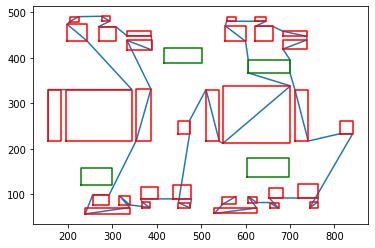

epoch:3, batch:1050/2500, reward:3664.04296875
epoch:3, batch:1100/2500, reward:3681.902587890625
epoch:3, batch:1150/2500, reward:3670.9931640625
epoch:3, batch:1200/2500, reward:3684.008056640625
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


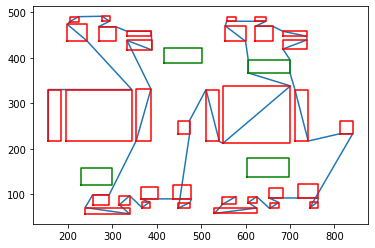

epoch:3, batch:1250/2500, reward:3678.299560546875
epoch:3, batch:1300/2500, reward:3670.79296875
epoch:3, batch:1350/2500, reward:3663.89306640625
epoch:3, batch:1400/2500, reward:3675.94482421875
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


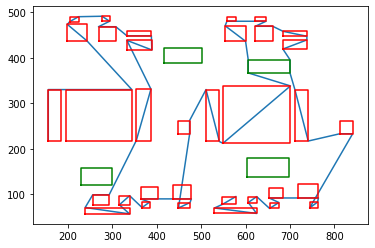

epoch:3, batch:1450/2500, reward:3723.366943359375
epoch:3, batch:1500/2500, reward:3677.042724609375
epoch:3, batch:1550/2500, reward:3665.072021484375
epoch:3, batch:1600/2500, reward:3669.18505859375
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


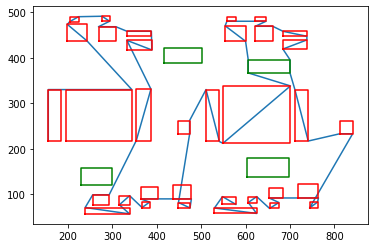

epoch:3, batch:1650/2500, reward:3663.406494140625
epoch:3, batch:1700/2500, reward:3675.91064453125
epoch:3, batch:1750/2500, reward:3663.42236328125
epoch:3, batch:1800/2500, reward:3672.71630859375
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


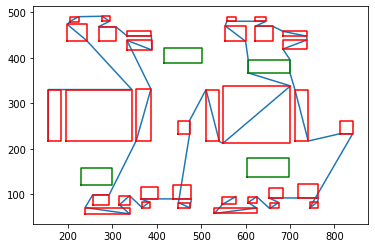

epoch:3, batch:1850/2500, reward:3685.62060546875
epoch:3, batch:1900/2500, reward:3663.778564453125
epoch:3, batch:1950/2500, reward:3663.8720703125
epoch:3, batch:2000/2500, reward:3665.06689453125
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


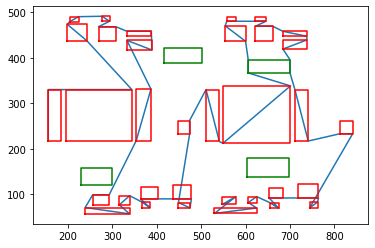

epoch:3, batch:2050/2500, reward:3664.302001953125
epoch:3, batch:2100/2500, reward:3655.759521484375
epoch:3, batch:2150/2500, reward:3662.62744140625
epoch:3, batch:2200/2500, reward:3653.479248046875
record the last path to gazebo for showing up
[12, 15, 113, 115]
[14, 13, 63, 61]


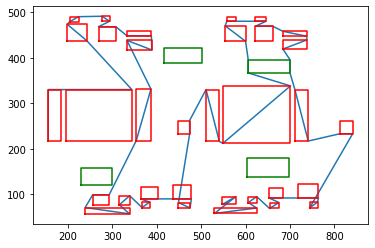

epoch:3, batch:2250/2500, reward:3660.39306640625
epoch:3, batch:2300/2500, reward:3665.430908203125
epoch:3, batch:2350/2500, reward:4473.6298828125
epoch:3, batch:2400/2500, reward:6366.255859375
record the last path to gazebo for showing up
[2, 1, 8, 9, 7, 6]
[12, 15, 115, 113]
[5, 6, 63, 61]
[5, 4, 34, 32]


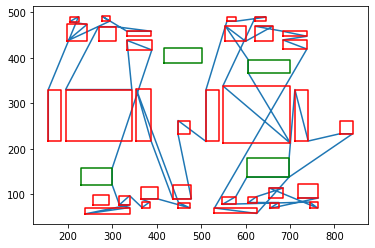

epoch:3, batch:2450/2500, reward:7356.8046875
epoch:3, batch:2500/2500, reward:6202.970703125
Avg Actor 5959.8115234375 --- Avg Critic 3672.813720703125
Epoch: 3, epoch time: 128.422min, tot time: 0.363day, L_actor: 5959.812, L_critic: 3672.814, update: False
Save Checkpoints
epoch:4, batch:50/2500, reward:5106.685546875
epoch:4, batch:100/2500, reward:4952.76025390625
epoch:4, batch:150/2500, reward:4854.333984375
epoch:4, batch:200/2500, reward:4767.896484375
record the last path to gazebo for showing up
[13, 14, 129, 131]


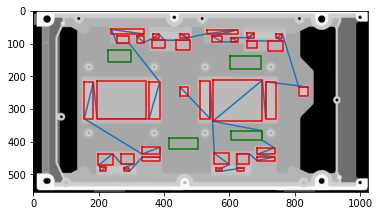

epoch:4, batch:250/2500, reward:4685.845703125
epoch:4, batch:300/2500, reward:4684.6123046875
epoch:4, batch:350/2500, reward:4628.31103515625
epoch:4, batch:400/2500, reward:4575.78369140625
record the last path to gazebo for showing up
[13, 14, 129, 131]


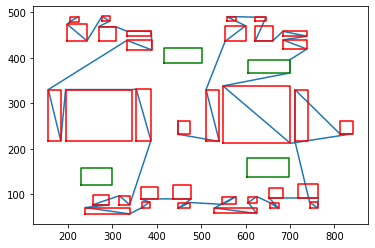

epoch:4, batch:450/2500, reward:4453.669921875
epoch:4, batch:500/2500, reward:4385.3115234375
epoch:4, batch:550/2500, reward:4351.57958984375
epoch:4, batch:600/2500, reward:4378.0908203125
record the last path to gazebo for showing up
[12, 15, 128, 130]


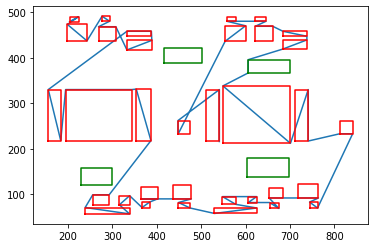

epoch:4, batch:650/2500, reward:4347.18994140625
epoch:4, batch:700/2500, reward:4359.845703125
epoch:4, batch:750/2500, reward:4330.0615234375
epoch:4, batch:800/2500, reward:4343.25341796875
record the last path to gazebo for showing up
[13, 14, 129, 131]


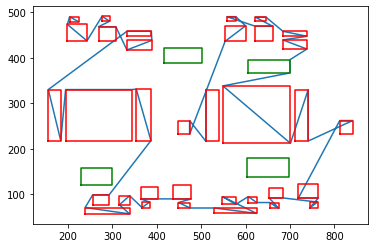

epoch:4, batch:850/2500, reward:4328.13720703125
epoch:4, batch:900/2500, reward:4330.18310546875
epoch:4, batch:950/2500, reward:4317.05810546875
epoch:4, batch:1000/2500, reward:4300.60498046875
record the last path to gazebo for showing up
[12, 15, 130, 128]


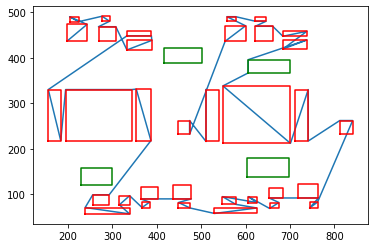

epoch:4, batch:1050/2500, reward:4298.6708984375
epoch:4, batch:1100/2500, reward:4292.54296875
epoch:4, batch:1150/2500, reward:4304.57080078125
epoch:4, batch:1200/2500, reward:4296.908203125
record the last path to gazebo for showing up
[12, 15, 134, 132]


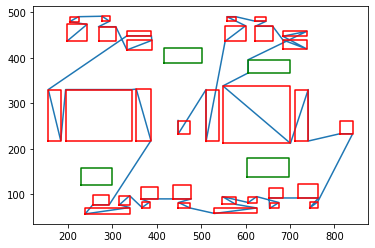

epoch:4, batch:1250/2500, reward:4334.50390625
epoch:4, batch:1300/2500, reward:4249.87109375
epoch:4, batch:1350/2500, reward:4250.6513671875
epoch:4, batch:1400/2500, reward:4244.259765625
record the last path to gazebo for showing up
[12, 15, 133, 135]


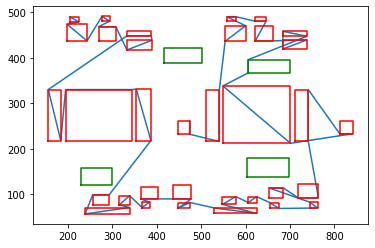

epoch:4, batch:1450/2500, reward:4244.65869140625
epoch:4, batch:1500/2500, reward:4208.2353515625
epoch:4, batch:1550/2500, reward:4241.578125
epoch:4, batch:1600/2500, reward:4216.29345703125
record the last path to gazebo for showing up
[13, 14, 129, 131]


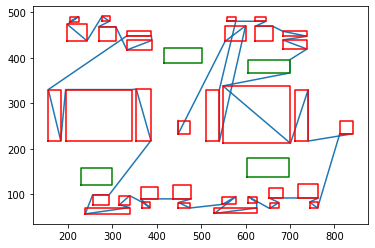

epoch:4, batch:1650/2500, reward:4221.90869140625
epoch:4, batch:1700/2500, reward:4177.2607421875
epoch:4, batch:1750/2500, reward:4215.20751953125
epoch:4, batch:1800/2500, reward:4220.9931640625
record the last path to gazebo for showing up
[12, 15, 128, 130]


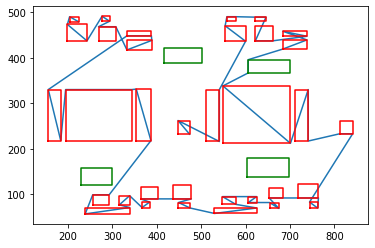

epoch:4, batch:1850/2500, reward:4182.14697265625
epoch:4, batch:1900/2500, reward:4165.40185546875
epoch:4, batch:1950/2500, reward:4201.4384765625
epoch:4, batch:2000/2500, reward:4204.6953125
record the last path to gazebo for showing up
[12, 15, 130, 128]


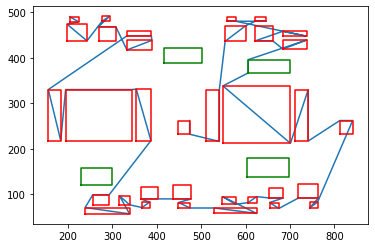

epoch:4, batch:2050/2500, reward:4171.880859375
epoch:4, batch:2100/2500, reward:4170.36083984375
epoch:4, batch:2150/2500, reward:4212.7470703125
epoch:4, batch:2200/2500, reward:4198.6474609375
record the last path to gazebo for showing up
[13, 14, 129, 131]


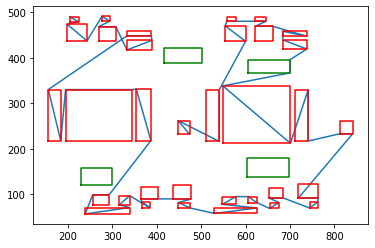

epoch:4, batch:2250/2500, reward:4145.9306640625
epoch:4, batch:2300/2500, reward:4211.771484375
epoch:4, batch:2350/2500, reward:4198.8173828125
epoch:4, batch:2400/2500, reward:4173.9140625
record the last path to gazebo for showing up
[12, 15, 134, 132]


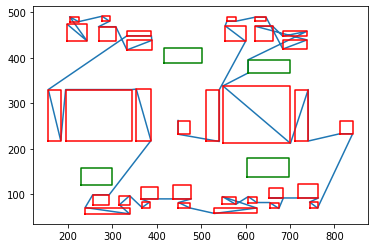

epoch:4, batch:2450/2500, reward:4220.61767578125
epoch:4, batch:2500/2500, reward:4173.69677734375
Avg Actor 4025.03759765625 --- Avg Critic 3672.813720703125
Epoch: 4, epoch time: 130.273min, tot time: 0.454day, L_actor: 4025.038, L_critic: 3672.814, update: False
Save Checkpoints
epoch:5, batch:50/2500, reward:4150.46044921875
epoch:5, batch:100/2500, reward:4154.35302734375
epoch:5, batch:150/2500, reward:4188.54443359375
epoch:5, batch:200/2500, reward:4181.52197265625
record the last path to gazebo for showing up
[12, 15, 135, 133]


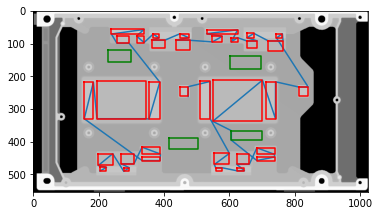

epoch:5, batch:250/2500, reward:4167.27734375
epoch:5, batch:300/2500, reward:4199.45751953125
epoch:5, batch:350/2500, reward:4186.21630859375
epoch:5, batch:400/2500, reward:4156.5458984375
record the last path to gazebo for showing up
[13, 14, 129, 131]


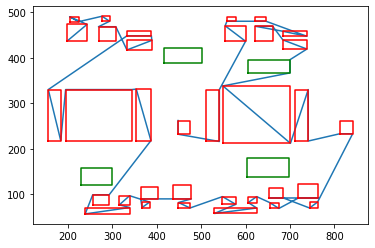

epoch:5, batch:450/2500, reward:4160.42919921875
epoch:5, batch:500/2500, reward:4176.9326171875
epoch:5, batch:550/2500, reward:4154.8056640625
epoch:5, batch:600/2500, reward:4177.623046875
record the last path to gazebo for showing up
[13, 14, 129, 131]


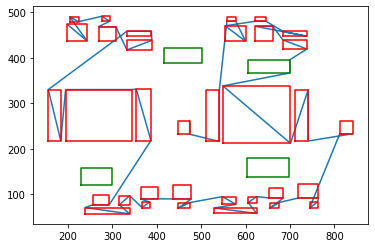

epoch:5, batch:650/2500, reward:4138.9072265625
epoch:5, batch:700/2500, reward:4164.5390625
epoch:5, batch:750/2500, reward:4158.39697265625
epoch:5, batch:800/2500, reward:4162.1298828125
record the last path to gazebo for showing up
[13, 14, 129, 131]


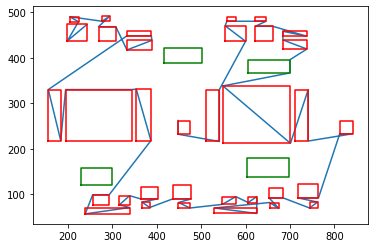

epoch:5, batch:850/2500, reward:4125.40673828125
epoch:5, batch:900/2500, reward:4118.69873046875
epoch:5, batch:950/2500, reward:4143.810546875
epoch:5, batch:1000/2500, reward:4115.6650390625
record the last path to gazebo for showing up
[13, 14, 129, 131]


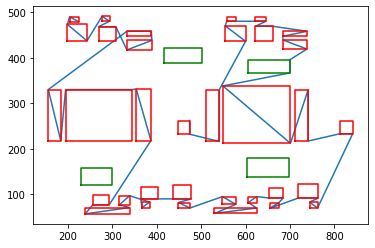

epoch:5, batch:1050/2500, reward:4123.86328125
epoch:5, batch:1100/2500, reward:4106.2529296875
epoch:5, batch:1150/2500, reward:4136.7568359375
epoch:5, batch:1200/2500, reward:4140.89013671875
record the last path to gazebo for showing up
[12, 15, 132, 134]


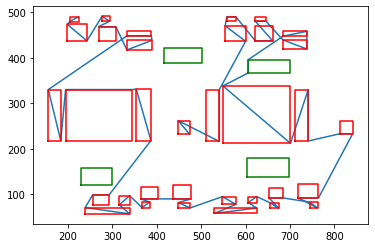

epoch:5, batch:1250/2500, reward:4122.26171875
epoch:5, batch:1300/2500, reward:4116.572265625
epoch:5, batch:1350/2500, reward:4141.1923828125
epoch:5, batch:1400/2500, reward:4178.10595703125
record the last path to gazebo for showing up
[2, 1, 6, 7]
[12, 15, 135, 133]


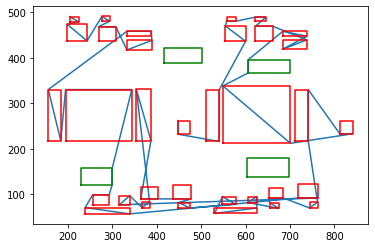

epoch:5, batch:1450/2500, reward:4125.4580078125
epoch:5, batch:1500/2500, reward:4099.6806640625
epoch:5, batch:1550/2500, reward:4132.06787109375
epoch:5, batch:1600/2500, reward:4140.0
record the last path to gazebo for showing up
[12, 15, 130, 128]


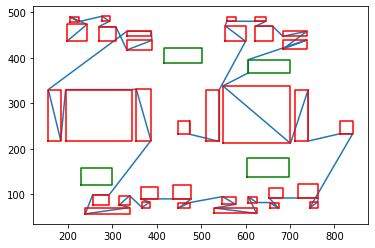

epoch:5, batch:1650/2500, reward:4140.21435546875
epoch:5, batch:1700/2500, reward:4138.099609375
epoch:5, batch:1750/2500, reward:4113.9443359375
epoch:5, batch:1800/2500, reward:4144.228515625
record the last path to gazebo for showing up
[12, 15, 132, 134]


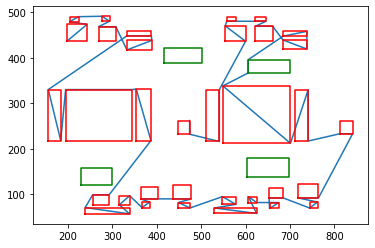

epoch:5, batch:1850/2500, reward:4132.2998046875
epoch:5, batch:1900/2500, reward:4123.63232421875
epoch:5, batch:1950/2500, reward:4111.3681640625
epoch:5, batch:2000/2500, reward:4103.48291015625
record the last path to gazebo for showing up
[13, 14, 129, 131]


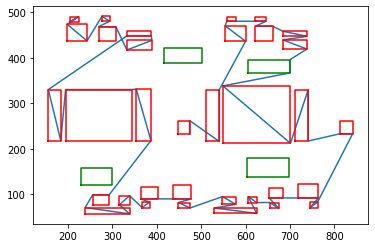

epoch:5, batch:2050/2500, reward:4129.57763671875
epoch:5, batch:2100/2500, reward:4143.9560546875
epoch:5, batch:2150/2500, reward:4122.095703125
epoch:5, batch:2200/2500, reward:4118.5498046875
record the last path to gazebo for showing up
[13, 14, 129, 131]


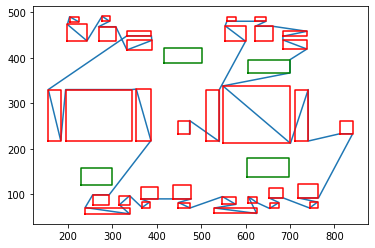

epoch:5, batch:2250/2500, reward:4142.5244140625
epoch:5, batch:2300/2500, reward:4123.703125
epoch:5, batch:2350/2500, reward:4130.1494140625
epoch:5, batch:2400/2500, reward:4092.996826171875
record the last path to gazebo for showing up
[12, 15, 132, 134]


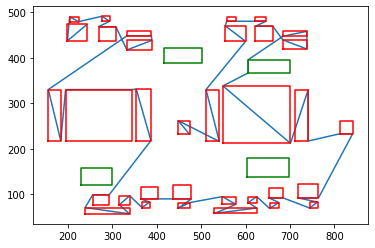

epoch:5, batch:2450/2500, reward:4092.87939453125
epoch:5, batch:2500/2500, reward:4101.66455078125
Avg Actor 4030.1923828125 --- Avg Critic 3672.813720703125
Epoch: 5, epoch time: 128.863min, tot time: 0.544day, L_actor: 4030.192, L_critic: 3672.814, update: False
Save Checkpoints
epoch:6, batch:50/2500, reward:4135.3828125
epoch:6, batch:100/2500, reward:4212.302734375
epoch:6, batch:150/2500, reward:4181.23291015625
epoch:6, batch:200/2500, reward:4121.873046875
record the last path to gazebo for showing up
[13, 14, 129, 131]


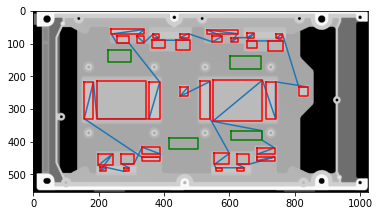

epoch:6, batch:250/2500, reward:4136.11767578125
epoch:6, batch:300/2500, reward:4142.9130859375
epoch:6, batch:350/2500, reward:4152.6435546875
epoch:6, batch:400/2500, reward:4146.77099609375
record the last path to gazebo for showing up
[12, 15, 132, 134]


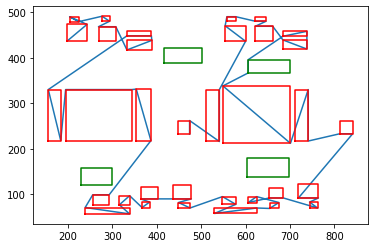

epoch:6, batch:450/2500, reward:4150.5048828125
epoch:6, batch:500/2500, reward:4154.0419921875
epoch:6, batch:550/2500, reward:4131.3603515625
epoch:6, batch:600/2500, reward:4100.1044921875
record the last path to gazebo for showing up
[12, 15, 135, 133]


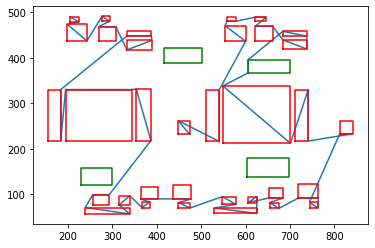

epoch:6, batch:650/2500, reward:4155.0361328125
epoch:6, batch:700/2500, reward:4104.931640625
epoch:6, batch:750/2500, reward:4243.08984375
epoch:6, batch:800/2500, reward:4101.92578125
record the last path to gazebo for showing up
[12, 15, 131, 129]


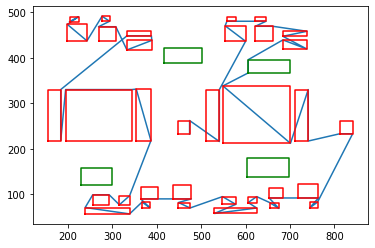

epoch:6, batch:850/2500, reward:4155.0791015625
epoch:6, batch:900/2500, reward:4099.1806640625
epoch:6, batch:950/2500, reward:4093.650146484375
epoch:6, batch:1000/2500, reward:4057.634033203125
record the last path to gazebo for showing up
[13, 14, 129, 131]


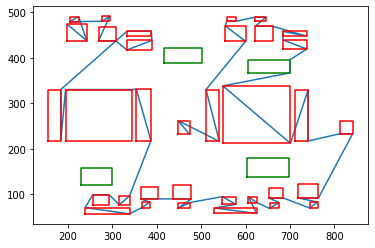

epoch:6, batch:1050/2500, reward:4115.1015625
epoch:6, batch:1100/2500, reward:4085.178466796875
epoch:6, batch:1150/2500, reward:4203.0126953125
epoch:6, batch:1200/2500, reward:4455.19921875
record the last path to gazebo for showing up
[8, 9, 87, 85]
[13, 14, 129, 131]


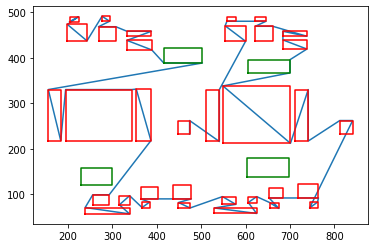

epoch:6, batch:1250/2500, reward:4438.48828125
epoch:6, batch:1300/2500, reward:4415.0830078125
epoch:6, batch:1350/2500, reward:4466.8037109375
epoch:6, batch:1400/2500, reward:4206.4482421875
record the last path to gazebo for showing up
[13, 14, 129, 131]


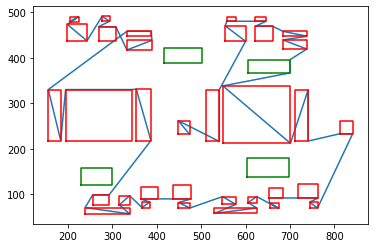

epoch:6, batch:1450/2500, reward:4155.15966796875
epoch:6, batch:1500/2500, reward:4158.74609375
epoch:6, batch:1550/2500, reward:4106.5791015625
epoch:6, batch:1600/2500, reward:4118.08544921875
record the last path to gazebo for showing up
[12, 15, 130, 128]


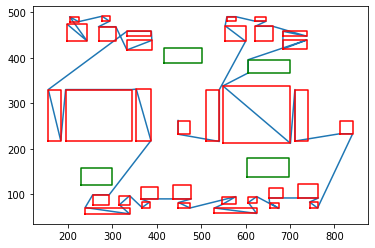

epoch:6, batch:1650/2500, reward:4102.54443359375
epoch:6, batch:1700/2500, reward:4122.2060546875
epoch:6, batch:1750/2500, reward:4110.1943359375
epoch:6, batch:1800/2500, reward:4116.505859375
record the last path to gazebo for showing up
[13, 14, 129, 131]


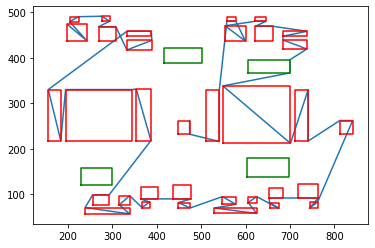

epoch:6, batch:1850/2500, reward:4151.2939453125
epoch:6, batch:1900/2500, reward:4142.67431640625
epoch:6, batch:1950/2500, reward:4109.65380859375
epoch:6, batch:2000/2500, reward:4110.72607421875
record the last path to gazebo for showing up
[13, 14, 129, 131]


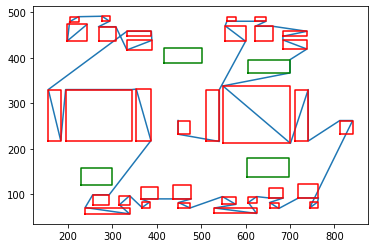

epoch:6, batch:2050/2500, reward:4113.3779296875
epoch:6, batch:2100/2500, reward:4110.72509765625
epoch:6, batch:2150/2500, reward:4103.779296875
epoch:6, batch:2200/2500, reward:4121.16796875
record the last path to gazebo for showing up
[12, 15, 131, 129]


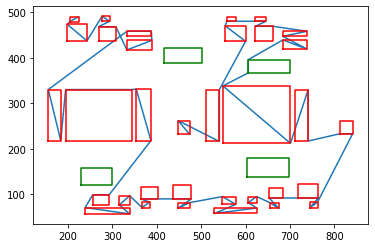

epoch:6, batch:2250/2500, reward:4134.8916015625
epoch:6, batch:2300/2500, reward:4127.3896484375
epoch:6, batch:2350/2500, reward:4109.30810546875
epoch:6, batch:2400/2500, reward:4107.830078125
record the last path to gazebo for showing up
[13, 14, 129, 131]


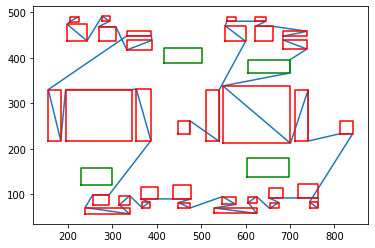

epoch:6, batch:2450/2500, reward:4103.20751953125
epoch:6, batch:2500/2500, reward:4161.7890625
Avg Actor 4032.57373046875 --- Avg Critic 3672.813720703125
Epoch: 6, epoch time: 128.488min, tot time: 0.634day, L_actor: 4032.574, L_critic: 3672.814, update: False
Save Checkpoints
epoch:7, batch:50/2500, reward:4094.47802734375
epoch:7, batch:100/2500, reward:4214.35986328125
epoch:7, batch:150/2500, reward:4151.3759765625
epoch:7, batch:200/2500, reward:4266.490234375
record the last path to gazebo for showing up
[13, 14, 129, 131]


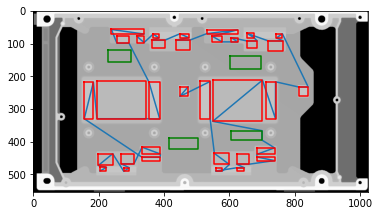

epoch:7, batch:250/2500, reward:4189.5947265625
epoch:7, batch:300/2500, reward:4156.3798828125
epoch:7, batch:350/2500, reward:4133.19189453125
epoch:7, batch:400/2500, reward:4139.310546875
record the last path to gazebo for showing up
[13, 14, 129, 131]


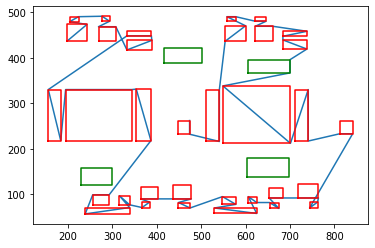

epoch:7, batch:450/2500, reward:4121.64306640625
epoch:7, batch:500/2500, reward:4114.20068359375
epoch:7, batch:550/2500, reward:4127.4765625
epoch:7, batch:600/2500, reward:4144.38818359375
record the last path to gazebo for showing up
[12, 15, 133, 135]


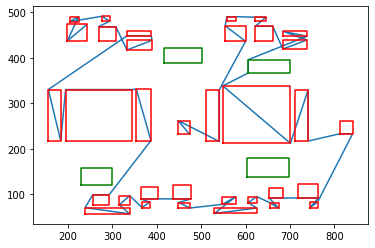

epoch:7, batch:650/2500, reward:4136.830078125
epoch:7, batch:700/2500, reward:4146.18505859375
epoch:7, batch:750/2500, reward:4133.876953125
epoch:7, batch:800/2500, reward:4128.0888671875
record the last path to gazebo for showing up
[13, 14, 129, 131]


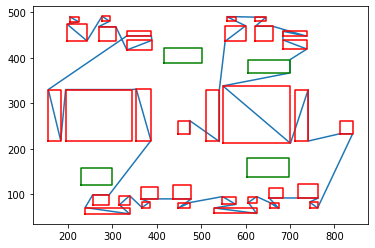

epoch:7, batch:850/2500, reward:4118.994140625
epoch:7, batch:900/2500, reward:4098.203125
epoch:7, batch:950/2500, reward:4093.5771484375
epoch:7, batch:1000/2500, reward:4080.17919921875
record the last path to gazebo for showing up
[13, 14, 129, 131]


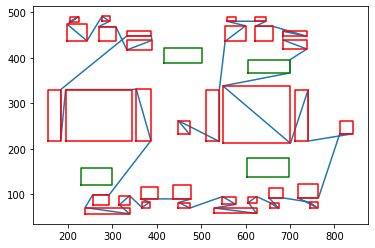

epoch:7, batch:1050/2500, reward:4079.564208984375
epoch:7, batch:1100/2500, reward:4107.4306640625
epoch:7, batch:1150/2500, reward:4108.9345703125
epoch:7, batch:1200/2500, reward:4120.94140625
record the last path to gazebo for showing up
[12, 15, 135, 133]


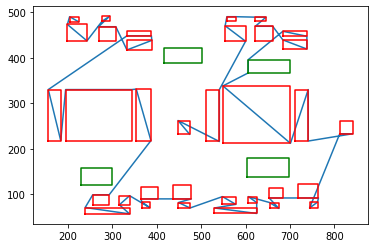

epoch:7, batch:1250/2500, reward:4110.7119140625
epoch:7, batch:1300/2500, reward:4108.01953125
epoch:7, batch:1350/2500, reward:4087.797607421875
epoch:7, batch:1400/2500, reward:4078.7646484375
record the last path to gazebo for showing up
[13, 14, 129, 131]


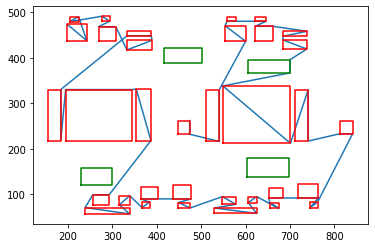

epoch:7, batch:1450/2500, reward:4066.002685546875
epoch:7, batch:1500/2500, reward:4100.05078125
epoch:7, batch:1550/2500, reward:4092.742431640625
epoch:7, batch:1600/2500, reward:4070.54248046875
record the last path to gazebo for showing up
[13, 14, 129, 131]


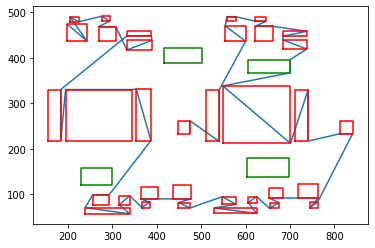

epoch:7, batch:1650/2500, reward:4074.94580078125
epoch:7, batch:1700/2500, reward:4071.261962890625
epoch:7, batch:1750/2500, reward:4075.5712890625
epoch:7, batch:1800/2500, reward:4110.64208984375
record the last path to gazebo for showing up
[13, 14, 129, 131]


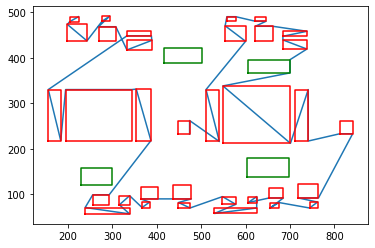

epoch:7, batch:1850/2500, reward:4114.1015625
epoch:7, batch:1900/2500, reward:4101.3203125
epoch:7, batch:1950/2500, reward:4096.34130859375
epoch:7, batch:2000/2500, reward:4093.414794921875
record the last path to gazebo for showing up
[13, 14, 129, 131]


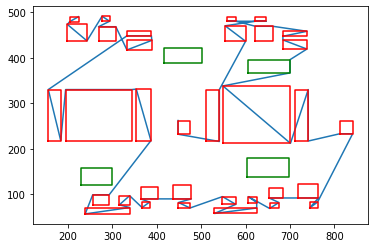

epoch:7, batch:2050/2500, reward:4104.81298828125
epoch:7, batch:2100/2500, reward:4095.06787109375
epoch:7, batch:2150/2500, reward:4128.32421875
epoch:7, batch:2200/2500, reward:4090.3876953125
record the last path to gazebo for showing up
[13, 14, 129, 131]


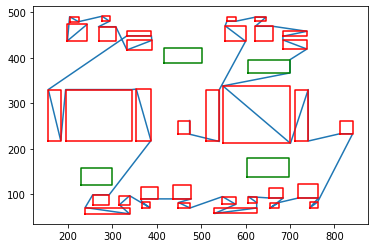

epoch:7, batch:2250/2500, reward:4092.059326171875
epoch:7, batch:2300/2500, reward:4087.82470703125
epoch:7, batch:2350/2500, reward:4092.988525390625
epoch:7, batch:2400/2500, reward:4269.63720703125
record the last path to gazebo for showing up
[12, 15, 130, 128]


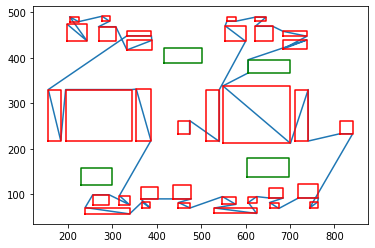

epoch:7, batch:2450/2500, reward:4123.3125
epoch:7, batch:2500/2500, reward:4107.724609375
Avg Actor 3965.8837890625 --- Avg Critic 3672.813720703125
Epoch: 7, epoch time: 127.387min, tot time: 0.724day, L_actor: 3965.884, L_critic: 3672.814, update: False
Save Checkpoints
epoch:8, batch:50/2500, reward:4110.9658203125
epoch:8, batch:100/2500, reward:4085.59716796875
epoch:8, batch:150/2500, reward:4084.21875


In [ ]:
import yaml
from torch.distributions.categorical import Categorical
# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm_notebook
####### my own import file ##########
from listofpathpoint import input_handler
import cnc_input
#from hybrid_models import HPN
####### my own import file ##########
'''
so, the models we have are TransEncoderNet,
                            Attention
                            LSTM
                            HPN
each one have initial parameters and the forward part, 
once we have the forward part, the back propagation will 
finished automatically by pytorch  
'''
size = 136
TOL = 1e-3
TINY = 1e-15
learning_rate = 1e-4   # learning rate
B = 256             # batch size
B_valLoop = 20
steps = 2500
n_epoch = 100       # epochs
size_rec = int(size/4)

print('======================')
print('prepare to train')
print('======================')
print('Hyper parameters:')
print('learning rate', learning_rate)
print('batch size', B)
print('steps', steps)
print('epoch', n_epoch)
print('======================')

'''
instantiate a training network and a baseline network
'''
temp = input_handler('mother_board.json')
barrier = input_handler('barrier.json')
'''
X_val consisted by 'list of list of list'
'rectangle list' 'channel list' 'point xy list' respectively
'''
try:
    del Actor  # remove existing model
    del Critic # remove existing model
except:
    pass
Actor = HPN(n_feature = 2, n_hidden = 128)
Critic = HPN(n_feature = 2, n_hidden = 128)
optimizer = optim.Adam(Actor.parameters(), lr=learning_rate)

# Putting Critic model on the eval mode
Actor = Actor.to(device)
Critic = Critic.to(device)
Critic.eval()

epoch_ckpt = 0
tot_time_ckpt = 0

val_mean = []
val_std = []

plot_performance_train = []
plot_performance_baseline = []
# recording the result of the resent epoch makes it available for future
#*********************# Uncomment these lines to load the previous check point

checkpoint_file = "checkpoint/checkpoint_21-12-13--20-14-17-n136-gpu0.pkl"
checkpoint = torch.load(checkpoint_file, map_location=device)
epoch_ckpt = checkpoint['epoch'] + 1
tot_time_ckpt = checkpoint['tot_time']
plot_performance_train = checkpoint['plot_performance_train']
plot_performance_baseline = checkpoint['plot_performance_baseline']
Critic.load_state_dict(checkpoint['model_baseline'])
Actor.load_state_dict(checkpoint['model_train'])
optimizer.load_state_dict(checkpoint['optimizer'])

print('Re-start training with saved checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))


#***********************# Uncomment these lines to load the previous check point

# Main training loop
# The core training concept mainly upon Sampling from the actor
# then taking the greedy action from the critic


start_training_time = time.time()
time_stamp = datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S") # Load the time stamp

C = 0       # baseline => the object which the actor can compare
R = 0       # reward

zero_to_bsz = torch.arange(B, device = device) # a list contains 0 to (batch size -1)

for epoch in range(0, n_epoch):
    
    # re-start training with saved checkpoint
    epoch += epoch_ckpt # adding the number of the former epochs
    # Train the model for one epoch
    start = time.time() # record the starting time
    Actor.train() 
    X_temp = temp.every_point()
    X_temp = torch.FloatTensor(X_temp)
    f_temp = input_handler('mother_board.json')
    b_temp = input_handler('barrier.json')
    X = X_temp.repeat(B,1,1)
    X = X.cuda()
    barrier_temp = barrier.every_point() #left up, right up, right down, left down
    barrier_once = torch.FloatTensor(barrier_temp)
    barrier_points = barrier_once.repeat(B,1,1)
    barrier_points = barrier_points.cuda()
    path_gazebo = []
    
    for i in range(1, steps+1): # 1 ~ 2500 steps
        mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        R = 0
        logprobs = 0
        reward = 0
        Y = X.view(B,size,2)
        x = torch.zeros(B,2) #Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None        #set Y_ini to the out corner
        Transcontext = None
        Y0 = None
        # Actor Sampling phase
        for k in range(size_rec):
            context, Transcontext, output, h, c, _ = Actor(context,Transcontext,x=x, X_all=X, h=h, c=c, mask=mask)
            sampler = torch.distributions.Categorical(output)
            idx = sampler.sample()
             #prepare for the back propagation of pytorch
            reward, Y0,x = rectangle_process_actor(b_temp,f_temp, idx,Y,Y0,mask,k,B,i,path_gazebo,barrier_points)
            R += reward
            logprobs += torch.log(output[zero_to_bsz, idx.data] + TINY)
            ##mask[zero_to_bsz, idx.data] += -np.inf
# critic baseline phase, use the baseline to compute the actual reward of agent at that time
        mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        C = 0
        baseline = 0
        Y = X.view(B,size,2)
        x = torch.zeros(B,2)#Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None
        Transcontext = None
        C0 = None
        # compute tours for baseline without grad "Cause we want to fix the weights for the critic"
        with torch.no_grad():
            for k in range(size_rec):      
                context, Transcontext, output, h, c, _ = Critic(context,Transcontext,x=x, X_all=X, h=h, c=c, mask=mask)
                idx = torch.argmax(output, dim=1) # ----> greedy baseline critic
                # prepare for the back propagation of pytorch
                baseline, C0,x = rectangle_process(b_temp,f_temp,idx,Y,C0, mask,k,B,barrier_points)
                C += baseline
        ###################
        # Loss and backprop handling 
        ###################
        
        loss = torch.mean((R - C) * logprobs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 50 == 0:
            print("epoch:{}, batch:{}/{}, reward:{}".format(epoch, i, steps, R.mean().item()))
        if i % 200 == 0:
            print("record the last path to gazebo for showing up")
            #starting to show the path on simulated enviroment of cnc_machine 
            the_resent_path = temp.zig_zag_path(path_gazebo,barrier_temp)
            data = {'path':the_resent_path}
            data_1 = {'corners':path_gazebo}
            pathpoints_dir = os.path.join("pathpoints")
            if not os.path.exists(pathpoints_dir):
                os.makedirs(pathpoints_dir)
            name = 'pathpoints/path_points '+str(i)+'.yaml'
            with open(name, 'w') as file:
                documents = yaml.dump(data,file)
                documents = yaml.dump(data_1,file)
            path_gazebo = []
    time_one_epoch = time.time() - start #recording the work time of one epoch
    time_tot = time.time() - start_training_time + tot_time_ckpt
    ###################
    # Evaluate train model and baseline 
    # in this phase we just solve random instances with the actor and the critic
    # compare this soluation if we get any improvment we'll transfer the actor's
    # weights into the critic
    ###################
    # putting the actor in the eval mode
    Actor.eval()
    
    mean_tour_length_actor = 0
    mean_tour_length_critic = 0

    for step in range(0,B_valLoop):
        
        # compute tour for model and baseline
        X_temp_val = temp.every_point()
        X_temp_val = torch.FloatTensor(X_temp_val)
        X_val = X_temp_val.repeat(B,1,1)
        X_val = X_val.cuda()
        mask = torch.zeros(B,size).cuda()
        R = 0
        reward = 0
        Y = X_val.view(B,size,2)
        x = torch.zeros(B,2)#Y[:,0,:] #set the first point to x
        Y0 = None
        h = None
        c = None
        context = None
        Transcontext = None

        with torch.no_grad():
            for k in range(size_rec):
                #same as the above part
                context, Transcontext, output, h, c, _ = Actor(context,Transcontext,x=x, X_all=X, h=h, c=c, mask=mask)
                idx = torch.argmax(output, dim=1)
                # prepare for the back propagation of pytorch
                reward, Y0,x = rectangle_process(b_temp,f_temp, idx,Y,Y0, mask,k,B,barrier_points)
                R += reward
        # critic baseline
        mask = torch.zeros(B,size).cuda()
        C = 0
        baseline = 0
        
        Y = X_val.view(B,size,2)
        x = torch.zeros(B,2)#Y[:,0,:] #set the first point to x
        
        h = None
        c = None
        context = None
        Transcontext = None
        
        with torch.no_grad():
            for k in range(size_rec):
                #same as the above part
                context, Transcontext, output, h, c, _ = Critic(context,Transcontext,x=x, X_all=X, h=h, c=c, mask=mask)
                idx = torch.argmax(output, dim=1)  
                # prepare for the back propagation of pytorch
                baseline, Y0,x = rectangle_process(b_temp,f_temp, idx,Y,Y0, mask,k,B,barrier_points)
                C += baseline

        mean_tour_length_actor  += R.mean().item()
        mean_tour_length_critic += C.mean().item()

    mean_tour_length_actor  =  mean_tour_length_actor  / B_valLoop
    mean_tour_length_critic =  mean_tour_length_critic / B_valLoop
    # evaluate train model and baseline and update if train model is better

    update_baseline = mean_tour_length_actor + TOL < mean_tour_length_critic

    print('Avg Actor {} --- Avg Critic {}'.format(mean_tour_length_actor,mean_tour_length_critic))

    if update_baseline:
        Critic.load_state_dict(Actor.state_dict())
        print('My actor is going on the right road Hallelujah :) Updated')
    ###################
    # Valdiation train model and baseline on 1k random TSP instances
    ###################
    # erased by daniel due to the 1K tsp is not the scale I want to train  

    # For checkpoint
    plot_performance_train.append([(epoch+1), mean_tour_length_actor])
    plot_performance_baseline.append([(epoch+1), mean_tour_length_critic])
    # compute the optimally gap ==> this is interesting because there is no LKH or other optimal algorithms 
    # for the problem like this rectangle characterized map
    mystring_min = 'Epoch: {:d}, epoch time: {:.3f}min, tot time: {:.3f}day, L_actor: {:.3f}, L_critic: {:.3f}, update: {}'.format(
        epoch, time_one_epoch/60, time_tot/86400, mean_tour_length_actor, mean_tour_length_critic, update_baseline)

    print(mystring_min)
    print('Save Checkpoints')

    # Saving checkpoint
    checkpoint_dir = os.path.join("checkpoint")

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    torch.save({
        'epoch': epoch,
        'time': time_one_epoch,
        'tot_time': time_tot,
        'loss': loss.item(),
        'plot_performance_train': plot_performance_train,
        'plot_performance_baseline': plot_performance_baseline,
        'model_baseline': Critic.state_dict(),
        'model_train': Actor.state_dict(),
        'optimizer': optimizer.state_dict(),
        },'{}.pkl'.format(checkpoint_dir + "/checkpoint_" + time_stamp + "-n{}".format(size) + "-gpu{}".format(gpu_id)))



  




                
            
                
        
                        

In [ ]:
import math 

def angle(v1):
    dx1 = v1[0]
    dy1 = v1[1]
    angle1 = math.atan2(dy1, dx1)
    angle1 = int(angle1 * 180/math.pi)
    if angle1 < 0:
        angle1 = 360 + angle1
    return angle1
print(angle([-1,-1]))

In [ ]:
students = [
['Joey', 'A', 15,3],
['Monica', 'B', 10,4],
['Ross', 'C', 8,55],
['Rachel', 'B', 12,2]
]
student_sort_1 = sorted(students)
students = sorted(students, key = lambda student : student[3])

print(student_sort_1)
#output:[[['Joey', 'A', 15], ['Monica', 'B', 10], ['Rachel', 'B', 12], ['Ross', 'C', 8]]
print(students)
#output:[['Ross', 'C', 8], ['Monica', 'B', 10], ['Rachel', 'B', 12], ['Joey', 'A', 15]]

In [ ]:
temp = [2,2]
temp_1 = [5,9]
temp_2 = set(temp) - set(temp_1)
print(temp_2)